# Appendix E. Machine Learning

The dataset consists of labelled IR spectra. Each spectrum is assigned to one or more labels, and the labels are not mutually exclusive. Therefore, we use multilabel classification techniques.

***
**Table of contents**
#### &nbsp;&nbsp; (I) Import and prepare dataset
#### &nbsp;&nbsp; (II) Apply a dimensionality reduction technique (i.e., PCA)
#### &nbsp;&nbsp; (III) Screen multiple models simultaneously
#### &nbsp;&nbsp; (IV) Optimize the parameters for DecisionTreesClassifier
#### &nbsp;&nbsp; (V) Estimate score uncertainty with k-fold cross-validation
#### &nbsp;&nbsp; (VI) Summary and next steps

***

### (I) Import and prepare dataset

### (a) Import data

In [1]:
#import data
import pandas as pd

df=pd.read_csv('data/NIST_selected_organic_spectra.csv')

df.head()

,Unnamed: 0,600,604,608,612,616,620,624,628,632,...,3464,3468,3472,3476,3480,3484,3488,3492,3496,label
0,1119-40-0,0.009480,0.011373,0.008950,0.010881,0.012741,0.012765,0.011669,0.010218,0.008583,...,0.007078,0.007871,0.009175,0.010160,0.010963,0.015177,0.013968,0.014654,0.014541,ester
1,120-33-2,0.001862,0.002358,0.000965,0.001367,0.001221,0.002217,0.001162,0.000631,0.001026,...,0.007558,0.006625,0.004902,0.004450,0.003911,0.003702,0.003551,0.002494,0.002388,ester
2,120-51-4,0.011749,0.009791,0.006795,0.006387,0.006919,0.005475,0.004003,0.002257,0.002252,...,0.005814,0.004950,0.004097,0.003773,0.003183,0.002548,0.002194,0.002459,0.002356,ester
3,120650-77-3,0.004431,0.005630,0.005578,0.005711,0.004729,0.003658,0.004980,0.003962,0.003673,...,0.004496,0.005218,0.003233,0.006065,0.004307,0.004863,0.005305,0.003419,0.005081,ester
4,1335-40-6,0.026083,0.025300,0.025201,0.024101,0.023793,0.022894,0.020080,0.016694,0.013240,...,0.005708,0.005478,0.005245,0.005083,0.005195,0.005259,0.005337,0.005369,0.005188,ester


In [2]:
df.shape #check


(405, 727)

### (b) Apply multilabel  

ref.: http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MultiLabelBinarizer.html

- The labels are:

In [3]:
#get the label names:
df.label.unique()

array(['ester', 'ketone', 'alcohol', 'alkane', 'alkene', 'amine',
       'aldehyde', 'acid', 'halide', 'benzene'], dtype=object)

#ref.: Brian C. Smith, "Infrared Spectral Interpretation: A Systematic Approach", CRC Press 1998.  
#we have ten labels:  
#Note: Aldehydes have the characteristic C-H stretch, denoted here as C-H_ald to differentiate from ketones.  

label_names=  
['C-H', 'C=C', \  #1,2    
'C=O', 'C-O', \  #3,4  
'O-H', 'C-N', \  #5,6  
'N-H', 'C-X', \  #7,8  
'Ar', 'C-H_ald'] #9,10    

Cheat-sheet:  
    ester=(1,3,4,,,,,,)  
    ketone=(1,3,,,,,,,)  
    alcohol=(1,4,5,,,,,)  
    alkane=(1,,,,,,,,)  
    alkene=(1,2,,,,,,,)  
    amine=(1,6,7,,,,,,)  
    aldehyde=(1,3,10,,,,,,)  
    alcid=(1,3,4,5,,,,,)  
    halide=(1,8,,,,,,,)  
    benzene=(1,2,9,,,,,,)  


In [4]:
#1. define labels for each functional group as a list.
ester_label=[1,3,4]  
ketone_label=[1,3]  
alcohol_label=[1,4,5]  
alkane_label=[1]  
alkene_label=[1,2]  
amine_label=[1,6,7]  
aldehyde_label=[1,3,10]  
acid_label=[1,3,4,5]  
halide_label=[1,8]  
benzene_label=[1,2,9]  


In [5]:
#create labels
from sklearn.preprocessing import MultiLabelBinarizer

mlb = MultiLabelBinarizer() #create object

#generate as many labels as there are entries in the respective groups and the combine it into a single array with row number matching with the Dataset
#https://stackoverflow.com/questions/19753279/repeat-a-tuple-inside-a-tuple
y_label=len(df[df.label=='ester'])*[ester_label,] + \
        len(df[df.label=='ketone'])*[ketone_label,] + \
        len(df[df.label=='alcohol'])*[alcohol_label,] + \
        len(df[df.label=='alkane'])*[alkane_label,] + \
        len(df[df.label=='alkene'])*[alkene_label,] + \
        len(df[df.label=='amine'])*[amine_label,] + \
        len(df[df.label=='aldehyde'])*[aldehyde_label,] + \
        len(df[df.label=='acid'])*[acid_label,] + \
        len(df[df.label=='halide'])*[halide_label,] + \
        len(df[df.label=='benzene'])*[benzene_label,] 

y_label=mlb.fit_transform(y_label) #convert tuples list to multilabelbinarizer
#len(y_label) #check
y_label #check


array([[1, 0, 1, ..., 0, 0, 0],
       [1, 0, 1, ..., 0, 0, 0],
       [1, 0, 1, ..., 0, 0, 0],
       ..., 
       [1, 1, 0, ..., 0, 1, 0],
       [1, 1, 0, ..., 0, 1, 0],
       [1, 1, 0, ..., 0, 1, 0]])

### (II) Screen various techniques

In [6]:
#1. split datasets into train/test datasets for PCA
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split( 
    df.iloc[:,1:726], y_label, test_size=0.2, random_state=13)

#2. normalize datasets
from sklearn.preprocessing import StandardScaler

scaler=StandardScaler().fit(X_train)
standardized_X=scaler.transform(X_train)
standardized_X_test=scaler.transform(X_test)

DTC: 0.530871 (0.076539)
ETC: 0.413447 (0.046810)
KNC: 0.548864 (0.082087)
ETC_E: 0.496875 (0.099581)
RFC: 0.518182 (0.078967)


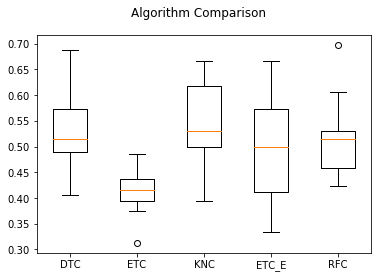

In [7]:
# Compare Algorithms
from pandas import read_csv
from matplotlib import pyplot
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import ExtraTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import RandomForestClassifier


# prepare models
models = []
models.append(('DTC', DecisionTreeClassifier())) 
models.append(('ETC', ExtraTreeClassifier()))
models.append(('KNC', KNeighborsClassifier()))
models.append(('ETC_E', ExtraTreesClassifier()))
models.append(('RFC', RandomForestClassifier()))


# evaluate each model in turn
results = []
names = []
scoring = 'accuracy'


for name, model in models: #iterate through each of the different models
    #Use k-fold validation to determine model accuracy. k-fold validation is one of many ways, but it is the gold standard way.
    try:
        kfold = KFold(n_splits=10, random_state=7) #initiate k-fold validation. Here, we use 10-folds.
        cv_results = cross_val_score(model, standardized_X, y_train, cv=kfold, scoring=scoring) #apply model in turns.
        results.append(cv_results)
        names.append(name)
    except:
        print('Error in:', name, 'and', model)
        
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)
    
# boxplot algorithm comparison
fig = pyplot.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
pyplot.boxplot(results)
ax.set_xticklabels(names)
pyplot.show()

-  It is seen that DecisionTreeClassifier yields the highest score of about 0.55 and a relatively narrow standard deviation.
- Next, I will utilize dimensionality reduction technique and simultaneously perform a hyperparameter tuning on this model.

### (III) Apply a dimensionality reduction technique (i.e., PCA)

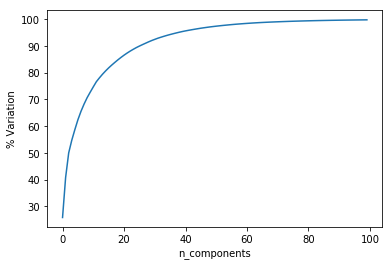

In [8]:
#Perform pca
from sklearn.decomposition import PCA

no_components=100

pca=PCA(n_components=no_components) #generate model

X_pca=pca.fit_transform(df.iloc[:,1:726])

#combine X_pca and y_label into a single dataframe and export to a csv file
#export the CAS index column as well
df_X_PCA_y_label=pd.DataFrame(X_pca) #create a DataFrame
df_X_PCA_y_label=pd.concat([df_X_PCA_y_label,pd.DataFrame(y_label)], axis=1)
df_X_PCA_y_label=pd.concat([df_X_PCA_y_label,df.iloc[:,0]], axis=1) #CAS number column

df_X_PCA_y_label.to_csv('data/df_X_PCA_y_label.csv', index=False)

#save pca model with pickle, so that it can be retrieved later
from pickle import dump

filename='data/pca_model.sav'
dump(pca,open(filename,'wb'))


import matplotlib.pyplot as plt
import numpy as np

plt.plot(np.arange(no_components),100*pca.explained_variance_ratio_.cumsum())

plt.xlabel('n_components')
plt.ylabel('% Variation')
plt.show()

- The above plot shows that n_component=100 is sufficient to capture close to 100% of all variations. Below, we will carry out hyperparameter tuning to determine the optimum parameters.

### (IV) Optimize the parameters for DecisionTreesClassifier

(a) pre-process data

In [9]:
#1. split datasets into train/test datasets for PCA
from sklearn.model_selection import train_test_split

X_train_pca, X_test_pca, y_train_pca, y_test_pca = train_test_split( 
    X_pca, y_label, test_size=0.2, random_state=13)

#2. scale datasets
scaler=StandardScaler().fit(X_train_pca)
standardized_X_pca=scaler.transform(X_train_pca)
standardized_X_test_pca=scaler.transform(X_test_pca)

(b) DecisionTreesClassifier
- Tune n_component and max_depth simultaneously

In [10]:
#Let's tune the parameters for DecisionTreeClassifier
components = [5, 10, 15, 20, 25, 30, 50, 100] #optimize using up to 100 components
max_depth = [10, 50, 100, 150, 200, 250] 

dtc_score=0 #temporarily stores previous score to be used to compare current with previous score
dtc_best=" " #a list for storing the best parameter for the knn model

print('Finding the best parameters, please wait...')

DecisionTreeClassifier()

for component in components:
    for n in max_depth:
        dtc = DecisionTreeClassifier(max_depth=n, random_state=0)
        dtc.fit(standardized_X_pca[:,:component], y_train_pca)
        score = dtc.score(standardized_X_test_pca[:,:component], y_test)
        
        if score>dtc_score:
            dtc_score=score
            dtc_best='components = ', component, ', max_depth = ', n,', Score = ', score
        
        #print('components = ', component, ', estimators = ', n,', Score = ', score)  

            
print('\n')
print('Best score:', dtc_best)

Finding the best parameters, please wait...


Best score: ('components = ', 20, ', max_depth = ', 10, ', Score = ', 0.59259259259259256)


- The highest score is 59% (components =  20 , max_depth =  10). 

### (V) Estimate score uncertainty with k-fold cross-validation

The ensemble methods perform similarly with DecisionTreeClassifier to give a score of about 60%. To determine the score uncertainty, I carry out k-fold cross-validation using the best-found parameters.  

In [11]:
# Evaluate DecisionTreeClassifier using k-fold cross-validation 
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

#combine scaled datasets
X=np.concatenate((standardized_X_pca,standardized_X_test_pca),axis=0)
Y=np.concatenate((y_train_pca,y_test_pca),axis=0)

In [13]:
n=10
component=28

num_folds = 10
seed = 7
kfold = KFold(n_splits=num_folds, random_state=seed)

etc = DecisionTreeClassifier(max_depth=n, random_state=0)
results = cross_val_score(etc, X[:,:component], Y, cv=kfold)

print("Accuracy: %.3f%% (%.3f%%)" % (results.mean()*100.0, results.std()*100.0))

Accuracy: 56.280% (5.786%)


- Therefore, the score accuracy of DecisionTreeClassifier model is 56.28 ± 5.79%.

### (VI) Summary and next steps

- Five machine learning models that are suitable for multilabel classification problems are assessed (i.e., DecisionTreeClassifier, ExtraTreeClassifier, ExtraTreesClassifier,  KNeighborsClassifier, and RandomForestClassifier).
- Initial screening reveals that DecisionTreeClassifier better than the other four algorithms with an accuracy score of about 55%. 
- Next, I utilize dimensionality reduction techniques (i.e., PCA) along with DecisionTreeClassifier to optimize the parameter in the model.The best score that is achieved is 59% (Components = 20 , max_depth = 10). This is a very modest score.  
- By carrying out k-fold cross-validation, the uncertainty in the score for DecisionTreeClassifier is 56.28 ± 5.79%.
- To further improve the model accuracy, next I consider a neural network model to achieve an accuracy score that is better than 56.28 ± 5.79% (see <b>Appendix F</b>). 
